# Classical methods in order to detect schizophrenia with EEG dataset

## Imports

In [1]:
import os
import mne
import numpy as np

from mne.filter import construct_iir_filter
from mne.preprocessing import ICA
from mne.io import RawArray

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.decomposition import FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from tools.eegPowerBand import eeg_power_band
from tools.MNEtoXYSets import transform

from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import acovf

## Loading EEG raw data

In [2]:
edfs_path = "..\dataverse_files"
manifest_path = "..\dataverse_files\MANIFEST.txt"

In [3]:
edfs_file_names = [f for f in os.listdir(edfs_path) if f.endswith('.edf')]

In [4]:
raw_patients_data = []

for file_name in edfs_file_names:
    path = edfs_path + '\\' + file_name 
    raw_data = mne.io.read_raw_edf(path, preload=True, verbose=False)
    raw_patients_data.append(raw_data)

## Preprocessing

#### Preprocessing with filtering (Butterworth lowpass filter 6th order with fcut=50Hz)

In [5]:
iir_filter = construct_iir_filter(dict(order=6, ftype='butter', output='sos'), 50, None, 250, 'low')


IIR filter parameters
---------------------
Butterworth low zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 12 (effective, after forward-backward)
- Cutoff at 50.00 Hz: -6.02 dB



In [6]:
edf_file = []

filtered_patients_data = [
    raw_patient_data
        .copy()
        .filter(l_freq=None, h_freq=None, picks='eeg', method='iir', iir_params=iir_filter, n_jobs=-1, verbose=False) 
    for raw_patient_data in raw_patients_data
]

#### Preprocessing with ICA

##### FASTICA From MNE

In [7]:
ica_patients_data = []
edf_file = []
ica_raw_patients_data = [raw_patient_data.copy().filter(l_freq=1., h_freq=None, verbose = False) for raw_patient_data in raw_patients_data]

In [8]:
for index, ica_raw_patient_data in enumerate(ica_raw_patients_data):
    # cov = mne.compute_raw_covariance(raw_patients_data[index], tstep = 25, verbose = False)
    ica = ICA(verbose = False)
    tmp = ica.fit(ica_raw_patient_data, verbose = False)
    ica_patients_data.append(tmp.get_sources(ica_raw_patient_data))

##### FASTICA from sklearn

In [9]:
fastICA = FastICA(whiten='unit-variance')
fastICAfeatures = [raw_patient_data.get_data() for raw_patient_data in raw_patients_data]
for index, patient in enumerate(raw_patients_data):
    fastICA.fit(patient.get_data()[:-1].reshape(-1, 1))
    fastICAfeatures[index][-1] = fastICA.transform(patient.get_data()[-1].reshape(-1, 1)).reshape(1, -1)

# fastICA = FastICA(1, whiten='unit-variance')
# fastICAfeatures = []
# for index, patient in enumerate(raw_patients_data):
#     fastICAfeatures.append(np.split(fastICA.fit_transform(patient.get_data().reshape(-1, 1)).reshape(-1, 1), 19))

In [10]:
baseRaw = []
edf_file = [raw_patient_data.filenames[0] for raw_patient_data in raw_patients_data]
for index, fastICAfeature in enumerate(fastICAfeatures):
    baseRaw.append(RawArray(fastICAfeature, raw_patients_data[index].info, verbose=False))

In [11]:
raw_patients_data[17].get_data()

array([[-1.50000000e-09, -1.50000000e-09, -8.95954558e-07, ...,
        -1.50000000e-09, -1.50000000e-09, -1.50000000e-09],
       [-1.50000000e-09, -1.50000000e-09, -3.59281823e-07, ...,
        -1.50000000e-09, -1.50000000e-09, -1.50000000e-09],
       [-1.50000000e-09, -1.50000000e-09, -5.38172735e-07, ...,
        -1.50000000e-09, -1.50000000e-09, -1.50000000e-09],
       ...,
       [-1.50000000e-09, -1.50000000e-09, -5.38172735e-07, ...,
        -1.50000000e-09, -1.50000000e-09, -1.50000000e-09],
       [-1.50000000e-09, -1.50000000e-09, -1.80390912e-07, ...,
        -1.50000000e-09, -1.50000000e-09, -1.50000000e-09],
       [-1.50000000e-09, -1.50000000e-09, -5.38172735e-07, ...,
        -1.50000000e-09, -1.50000000e-09, -1.50000000e-09]])

## Transform MNE data to features and label arrays

In [12]:
X, y = transform(baseRaw, edf_file = edf_file)

Not setting metadata
1142 matching events found
No baseline correction applied
0 bad epochs dropped


## Extraction

#### Energy band

In [13]:
featuresEEGPowerBand = eeg_power_band(X)

Effective window size : 1.024 (s)


In [14]:
featuresEEGPowerBand.shape

(1142, 95)

#### Variance

In [15]:
print(X.get_data().shape)
featuresVar = []
for index, feature in enumerate(X.get_data()):
    featuresVar.append(np.var(feature, axis = 1))

print(np.array(featuresVar).shape)

(1142, 19, 6250)
(1142, 19)


#### Autoregression

In [16]:
# for feature in features:
sel = acovf(X.get_data()[0][0].tolist())
print(sel)

[6.90081278e-11 6.43982526e-11 5.94461871e-11 ... 1.74819574e-16
 1.27549712e-16 6.51502722e-17]


#### L1 Norm

In [17]:
featuresVar = []
for index, feature in enumerate(X.get_data()):
    featuresVar.append([np.linalg.norm(feature, ord = 1)])

print(np.array(featuresVar))

[[3.30025148]
 [3.89063419]
 [4.67783816]
 ...
 [0.92825996]
 [0.66011985]
 [0.67569227]]


## Selection

#### PCA

#### LDA

In [18]:
lda = LinearDiscriminantAnalysis()
test = lda.fit_transform(featuresVar, y).T
test.flatten()

array([ 0.086316  ,  0.18042409,  0.30590586, ..., -0.29178383,
       -0.33452586, -0.33204359])

## Classification

In [19]:
X_train, X_test, y_train, y_test = train_test_split(test.flatten(), y, test_size=0.33, shuffle=True, random_state=41)

#### KNN

0.5994694960212201


c:\Users\Bartosz Ziomek\anaconda3\envs\thesis\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


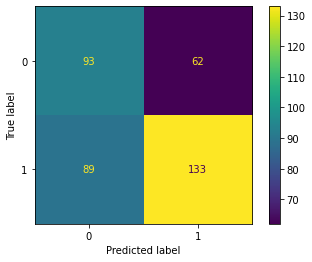

In [28]:
knn = KNeighborsClassifier()
knn.fit(X_train.reshape(-1, 1), y_train)
print(knn.score(X_test.reshape(-1, 1), y_test))
plot_confusion_matrix(knn, X_test.reshape(-1, 1), y_test)

## Statitics

## Others

##### Without scaling

In [21]:
def class_test(features, y, clr):
    X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.33, shuffle=True, random_state=41)

    pipe = make_pipeline(
        clr
    )

    # Train
    pipe.fit(X_train, y_train)

    # Test
    y_pred = pipe.predict(X_test)

    # Assess the results
    acc = accuracy_score(y_test, y_pred)

    return acc

##### With MinMaxScaler

In [22]:
# X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.33, shuffle=True, random_state=41)

# pipe = make_pipeline(
#     MinMaxScaler(copy=False),
#     RandomForestClassifier(n_estimators=100, random_state=42),
# )

# # Train
# pipe.fit(X_train, y_train)

# # Test
# y_pred = pipe.predict(X_test)

# # Assess the results
# acc = accuracy_score(y_test, y_pred)

# print("Accuracy score: {}".format(acc))

##### With MinMaxScaler

In [23]:
# X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.33, shuffle=True, random_state=41)

# pipe = make_pipeline(
#     StandardScaler(copy=False),
#     RandomForestClassifier(n_estimators=100, random_state=42),
# )

# # Train
# pipe.fit(X_train, y_train)

# # Test
# y_pred = pipe.predict(X_test)

# # Assess the results
# acc = accuracy_score(y_test, y_pred)

# print("Accuracy score: {}".format(acc))

##### With RobustScaler

In [24]:
# X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.33, shuffle=True, random_state=41)

# pipe = make_pipeline(
#     RobustScaler(copy=False),
#     RandomForestClassifier(n_estimators=100, random_state=42),
# )

# # Train
# pipe.fit(X_train, y_train)

# # Test
# y_pred = pipe.predict(X_test)

# # Assess the results
# acc = accuracy_score(y_test, y_pred)

# print("Accuracy score: {}".format(acc))

### Cross Validatated Classification

In [25]:
# clf = RandomForestClassifier(n_estimators=100, random_state=42)
# scores = cross_val_score(clf, features, y, cv=3)

# print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

### Test

In [26]:
clr_arr = [KNeighborsClassifier(n_neighbors=2),
            RandomForestClassifier(n_estimators=100, random_state=42),
            SVC(kernel='poly')]

res_acc_arr = []

In [27]:
for index1, clr in enumerate(clr_arr):
    with open(f'result{index1 + 1}.txt', 'w', encoding = 'utf-8') as f:
        acc_arr = []

        for index, i in enumerate(iir):
            filtered_patients_data = [raw_patient_data.copy()
                                  .filter(l_freq=None, h_freq=None, picks='eeg', method='iir', iir_params=i, n_jobs=-1, verbose=False) 
                                  for raw_patient_data in raw_patients_data]

            X, y = transform_patients_data_into_X_y_sets(filtered_patients_data)

            features = eeg_power_band(X)

            acc = class_test(features, y, clr)
            acc_arr.append(acc)

            filtered_patients_data = []
            X = []
            y = []
            features = []
            f.write(f"{iir_filter_dataset[index]} Accuracy score: {acc}\n")

        max_acc = max(acc_arr)
        f.write(f"{iir_filter_dataset[acc_arr.index(max_acc)]} -> {max_acc}\n")
    res_acc_arr.append(acc_arr)

NameError: name 'iir' is not defined

In [ ]:
np.average(np.array(res_acc_arr).T, axis = 1), max(np.average(np.array(res_acc_arr).T, axis = 1))

In [ ]:
iir_filter_dataset = [
    {'order': 2, 'flow': 0.5, 'fhigh': 50},
    {'order': 5, 'flow': 0.5, 'fhigh': 50},
    {'order': 6, 'flow': 0.5, 'fhigh': 50},
    {'order': 2, 'flow': 2, 'fhigh': 45},
    {'order': 5, 'flow': 2, 'fhigh': 45},
    {'order': 6, 'flow': 2, 'fhigh': 45},
    {'order': 5, 'flow': 0.5, 'fhigh': 45},
    {'order': 6, 'flow': 0.5, 'fhigh': 45},
    {'order': 81, 'fcut': 40, 'fstop': 45},
    {'order': 5, 'fcut': 50},
    {'order': 6, 'fcut': 50},
]